<a href="https://colab.research.google.com/github/fmakkawi/Data201/blob/main/Project_2_DATA_201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()


Saving Electric_Vehicle_Population_Data.csv to Electric_Vehicle_Population_Data.csv


In [5]:
# ----------------------------------------------
# Data Loading and Cleaning
# Done by: Farah Makkawi
# ----------------------------------------------

import pandas as pd

# Load after uploading using files.upload()
df = pd.read_csv("Electric_Vehicle_Population_Data.csv", encoding="latin-1", on_bad_lines='skip')

df = df.rename(columns=lambda x: x.strip())

print("Column names in the dataset:")
print(df.columns.tolist())

df = df[df["State"] == "WA"].copy()

df = df.dropna(subset=["Model Year", "Electric Range", "Base MSRP", "Electric Vehicle Type"])

print("Dataset loaded and cleaned. New shape:", df.shape)
df.head()


Column names in the dataset:
['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']
Dataset loaded and cleaned. New shape: (263965, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,WA1E2AFY8R,Thurston,Olympia,WA,98512.0,2024,AUDI,Q5 E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,23.0,0.0,22.0,263239938,POINT (-122.90787 46.9461),PUGET SOUND ENERGY INC,5.306701e+10
1,WAUUPBFF4J,Yakima,Wapato,WA,98951.0,2018,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16.0,0.0,15.0,318160860,POINT (-120.42083 46.44779),PACIFICORP,5.307794e+10
2,1N4AZ0CP0F,King,Seattle,WA,98125.0,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,46.0,184963586,POINT (-122.30253 47.72656),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
3,WA1VAAGE5K,King,Kent,WA,98031.0,2019,AUDI,E-TRON,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,204.0,0.0,11.0,259426821,POINT (-122.17743 47.41185),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
4,7SAXCAE57N,Snohomish,Bothell,WA,98021.0,2022,TESLA,MODEL X,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,1.0,208182236,POINT (-122.18384 47.8031),PUGET SOUND ENERGY INC,5.306105e+10


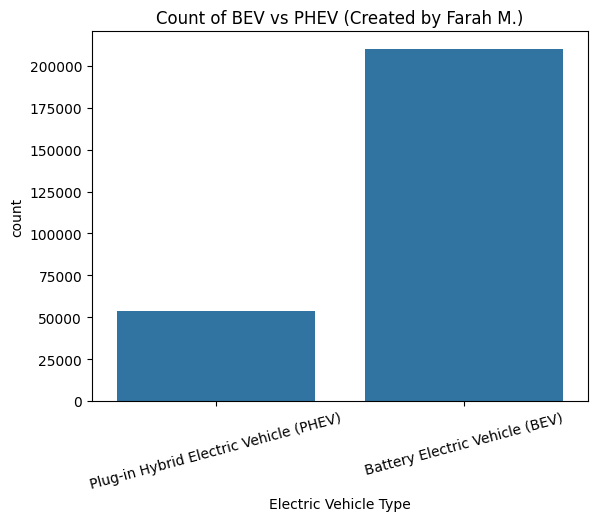

In [6]:
# ----------------------------------------------
# Basic EDA – Simple visualization
# Done by: Farah Makkawi
# ----------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x="Electric Vehicle Type")
plt.title("Count of BEV vs PHEV (Created by Farah M.)")
plt.xticks(rotation=15)
plt.show()


In [7]:
# ----------------------------------------------
# Logistic Regression Model
# Done by: Farah Makkawi
# ----------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Turn EV type into binary: 1 = BEV, 0 = PHEV
df["is_bev"] = (df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)").astype(int)

# Select input features
X = df[["Model Year", "Electric Range", "Base MSRP"]]
y = df["is_bev"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Predict
y_pred = log_model.predict(X_test_scaled)

# Show results
print("Logistic Regression Accuracy (Farah):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy (Farah): 0.8071335214895914

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.08      0.14     10775
           1       0.81      0.99      0.89     42018

    accuracy                           0.81     52793
   macro avg       0.79      0.54      0.52     52793
weighted avg       0.80      0.81      0.74     52793

Confusion Matrix:
 [[  822  9953]
 [  229 41789]]
